<a href="https://colab.research.google.com/github/AmurdAmzer/SAKT-Paper_Implementation/blob/main/SAKTPaperImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Uploading data via Colab's File Browser

In [24]:
# Cell 1: Uploading data via Colab's File Browser

# os stands for "Operating System" - it's like a special toolkit that lets your Python code talk to your computer's file system.
import os
print("Files in current directory:")
for file in os.listdir():
  if file.endswith(".csv"):
    print(f" - {file}")

Files in current directory:
 - skill_builder_data_corrected_collapsed.csv


#Cell 2: Imports and File upload

In [25]:
# Cell 2: Imports and File upload (df = pd.read_csv(....)) opens the spreadsheet(data) and puts it into a "DataFrame"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file (Remember to use the actual file name)
# encoding='ISO-8859-1' handles special characters in the data
# low_memory=False prevents dtype warnings for mixed types

# I choose to call my loaded data df, df can mean DataFrame, df is just a variable name, I can choose to name my uploaded data anything.
# low_memory=False tells the computer "take your time reading this properly, don't rush"
# encoding='ISO-8859-1' = Like telling your computer "hey, this file might have special characters like currency symbols ($ etc.)".
#  Real-Life Analogy
"""
It's like telling your computer:
When you read this file, treat these bytes or symbols as Latin-style letters — not random gibberish."

If you don't specify the correct encoding, Python might fail to read the file
"""

df = pd.read_csv('skill_builder_data_corrected_collapsed.csv', encoding='ISO-8859-1', low_memory=False)

# Show basic information about the dataset
print(f"Dataset shape: {df.shape}") # (rows, columns)
print(f"\nColumn names: {list(df.columns)}") # all column names
print(f"\nFirst 5 rows: {df.head()}") # preview first 5 rows. head() has a default parameter built in df.head(n=5). you could specify by df.head(5) etc.


Dataset shape: (346860, 31)

Column names: ['Unnamed: 0', 'order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id', 'original', 'correct', 'attempt_count', 'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time', 'template_id', 'answer_id', 'answer_text', 'first_action', 'bottom_hint', 'opportunity', 'opportunity_original']

First 5 rows:    Unnamed: 0  order_id  assignment_id  user_id  assistment_id  problem_id  \
0           1  33022537         277618    64525          33139       51424   
1           2  33022709         277618    64525          33150       51435   
2           3  35450204         220674    70363          33159       51444   
3           4  35450295         220674    70363          33110       51395   
4           5  35450311         220674    70363          33196       51481   

   original 

# Cell3: Key Statistics - Understanding the dataset size and scope

In [26]:
# Cell 3: Key Statistics - Understanding the dataset size and scope

print("===DATASET OVERVIEW===")

# Count total number of student interactions = number of rows
print(f"Toatal interactions: {len(df)}")

# Count unique students - each student has a unique user_id
print(f"Unique students: {df['user_id'].nunique()}") # df['user_id] = access the user id column. nunique = count how many unique values are in that column

# Count unique problems - individual questions students attempted
print(f"Unique problems: {df['problem_id'].nunique()}")

# Count unique skills - knowledge concepts being tested. this is crucial because I will create embeddings for each skill
print(f"Unique skills: {df['skill_id'].nunique()}")

# Calculate overall performance - percentage of correct answers
print(f"\nCorrect rate: {df['correct'].mean():.2%}")  # .2% means format the number as percentage with two decimal places, so for eg. 0.825641 becomes 82.56%

# Check data completeness for skill_id (Critical for SAKT)
# NB. SAKT needs skill_id to work - rows without the skill_id must be removed
print(f"Rows with skill_id: {df['skill_id'].notna().sum()}")
print(f"Rows missing skill_id: {df['skill_id'].isna().sum()} ({df['skill_id'].isna().mean():.1%})")


===DATASET OVERVIEW===
Toatal interactions: 346860
Unique students: 4217
Unique problems: 26688
Unique skills: 149

Correct rate: 64.53%
Rows with skill_id: 283105
Rows missing skill_id: 63755 (18.4%)


# CELL 4: Examine One Student's Learning Journey (Creating a case study).
# Before SAKT learns from all students, you want to see what one student's learning path looks like
# This helps to understand the sequential nature of the data

In [27]:
# Cell 4: Examine One Student's (random) Learning Journey
# This helps us understand the sequential nature of the data

# Find students sorted by number of attempts (most active students)
student_activity = df['user_id'].value_counts()

# Pick the 11th most active student (avoid outliers)
student_id = student_activity.index[20]

# Get all data for this student, sorted by time
# Order_id represents the sequence of attempsts

student_data = df[df['user_id'] == student_id].sort_values('order_id')

# Display student summary
print(f"Student {student_id} attempted {len(student_data)} problems")
print(f"Skills attempted: {student_data['skill_id'].nunique()}")
print(f"Correct rate: {student_data['correct'].mean():.2%}")

# Show their first 30 attempts to see the sequential Pattern
print("\nFirst 30 attempts:")
print(student_data[['order_id', 'skill_id', 'correct', 'ms_first_response']].head(30))

Student 96235 attempted 977 problems
Skills attempted: 87
Correct rate: 58.03%

First 30 attempts:
        order_id skill_id  correct  ms_first_response
96959   38171250       49        0               6228
96960   38171251       49        1               4544
96961   38171252       49        1               6059
96962   38171253       49        0               6154
96963   38171254       49        0              11896
96964   38171255       49        1              11180
96965   38171256       49        0               5603
96966   38171257       49        0               5152
96967   38171258       49        0               8184
96968   38171259       49        0               3551
96969   38171260       49        1               7122
96970   38171261       49        1               4576
96971   38171262       49        0               4139
96972   38171263       49        0               6022
96973   38171264       49        0              14956
96974   38171265       49        1   

# CELL 5: Visualize Key Patterns to Understand The Data Better

In [28]:
# CELL 5: Visualing Key Patterns to Understand the Data Better

# Calculate seuence length for each student (how many problems/quenstions/skills did each student attempt)

seq_lengths = df.groupby('user_id').size()

# seq_len for the Top 20 students
print("top 20 Most Active Students:")
print("user_id: sequence length")
sorted_seq = seq_lengths.sort_values(ascending=False)
for user_id, length in sorted_seq.head(20).items():
  print(f"{user_id}:     {length}")

print("\n")


# seq_len for the Buttom 20 students
print("Buttom 20 Least Active Students:")
print("user_id: sequence length")
sorted_seq = seq_lengths.sort_values(ascending=False)
for user_id, length in sorted_seq.tail(20).items():
  print(f"{user_id}:     {length}")

print("\n")

# Random 20 students sorted by length
print("20 Random students sorted by length")
print("user_id: sequence length")
random_sample = seq_lengths.sample(20).sort_values() # If you remove the ascending argument, pandas uses the default, which is: ascending=True
for user_id, length in random_sample.items():
  print(f"{user_id}:     {length}")





top 20 Most Active Students:
user_id: sequence length
78978:     1383
78970:     1334
79032:     1264
79021:     1239
96274:     1236
78979:     1163
96244:     1149
75169:     1129
79013:     1124
78989:     1115
79029:     1112
78980:     1112
79019:     1095
71881:     1089
78987:     1084
96243:     1083
79031:     1064
79018:     1041
96265:     1014
79012:     1005


Buttom 20 Least Active Students:
user_id: sequence length
87330:     1
87336:     1
87337:     1
91464:     1
91439:     1
87376:     1
92527:     1
85549:     1
85553:     1
85554:     1
85555:     1
85556:     1
85558:     1
85367:     1
77725:     1
74701:     1
71163:     1
84309:     1
51933:     1
84305:     1


20 Random students sorted by length
user_id: sequence length
78101:     1
82767:     6
71570:     6
88654:     7
82286:     10
91444:     13
86758:     18
80357:     22
78763:     27
78593:     27
87135:     32
85200:     46
86303:     76
78875:     90
78771:     94
88130:     144
79618:     178
79061: 

# CELL 6: Data Quality Check - Critical for Reliable Model Training

In [29]:
# CELL 6: Data Quality Check - Critical for Reliable Model Training

print("Data Quality Report:")
print("-" * 40)

# Check 1: Duplicate rows (same data appearing multiple times)
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("Need to remove duplicates!")

# Check 2: Students with very few attempts
# SAKT needs sufficient history to learn patterns
too_few = (seq_lengths < 5).sum()
print(f"Students with <5 attempts: {too_few} ({too_few/len(seq_lengths)*100:.1f}%)")

# Check 3: Students with too many attempts (potential outliers)
too_many = (seq_lengths > 500).sum()
print(f"Students with >500 attempts: {too_many}")

# Check 4: Temporal ordering validation
# Sort by user and order_id to check sequence integrity
df_sorted = df.sort_values(['user_id', 'order_id'])
# For each user, check if order_id always increases
is_ordered = df_sorted.groupby('user_id')['order_id'].apply(
    lambda x: (x.diff().dropna() > 0).all()  # diff() calculates difference between consecutive values
).all()
print(f"All sequences properly ordered: {is_ordered}")

# Check 5: Original vs scaffolding problems
# Original = main problem, scaffolding = hints/sub-problems
original_count = (df['original'] == 1).sum()
scaffold_count = (df['original'] == 0).sum()
print(f"\nOriginal problems: {original_count} ({original_count/len(df)*100:.1f}%)")
print(f"Scaffolding problems: {scaffold_count} ({scaffold_count/len(df)*100:.1f}%)")
print("SAKT paper uses only original problems")

# Check 6: Answer distribution
print(f"\nAnswer distribution:")
print(f"Correct: {(df['correct'] == 1).sum()} ({df['correct'].mean()*100:.1f}%)")
print(f"Incorrect: {(df['correct'] == 0).sum()} ({(1-df['correct'].mean())*100:.1f}%)")

# Check 7: Critical missing data for SAKT
print(f"\nMissing data analysis:")
print(f"Missing skill_id: {df['skill_id'].isna().sum()} rows ({df['skill_id'].isna().mean()*100:.1f}%)")
print(f"Missing user_id: {df['user_id'].isna().sum()} rows")
print(f"Missing correct: {df['correct'].isna().sum()} rows")
print("SAKT requires skill_id, user_id, and correct to be present")

Data Quality Report:
----------------------------------------
Duplicate rows: 0
Students with <5 attempts: 473 (11.2%)
Students with >500 attempts: 181
All sequences properly ordered: True

Original problems: 275458 (79.4%)
Scaffolding problems: 71402 (20.6%)
SAKT paper uses only original problems

Answer distribution:
Correct: 223818 (64.5%)
Incorrect: 123042 (35.5%)

Missing data analysis:
Missing skill_id: 63755 rows (18.4%)
Missing user_id: 0 rows
Missing correct: 0 rows
SAKT requires skill_id, user_id, and correct to be present


# CELL 7: Data Preprocessing for SAKT

In [30]:
# CELL 7: Data Preprocessing for SAKT

print("Starting data preprocessing...")
print(f"Original data shape: {df.shape}")

# Step 1: Keep only original problems (main problems, not hints)
# SAKT paper specifies using only original problems
df_clean = df[df['original'] == 1].copy()
print(f"\nAfter keeping only original problems: {df_clean.shape}")

# Step 2: Remove rows with missing skill_id
# SAKT requires skill_id to create embeddings
df_clean = df_clean.dropna(subset=['skill_id'])
print(f"After removing missing skill_id: {df_clean.shape}")

# Step 3: Convert skill_id to integer (it might be float due to NaN values)
df_clean['skill_id'] = df_clean['skill_id'].astype(int)

# Step 4: Calculate sequence lengths per student
student_seq_lengths = df_clean.groupby('user_id').size()

# Step 5: Keep only students with >= 5 attempts
# Too few attempts don't provide enough learning history
valid_students = student_seq_lengths[student_seq_lengths >= 20].index
df_clean = df_clean[df_clean['user_id'].isin(valid_students)]
print(f"After removing students with <5 attempts: {df_clean.shape}")

# Step 6: Sort by user_id and order_id (temporal order)
df_clean = df_clean.sort_values(['user_id', 'order_id'])

print(f"\nFinal clean dataset:")
print(f"- Total interactions: {len(df_clean)}")
print(f"- Unique students: {df_clean['user_id'].nunique()}")
print(f"- Unique skills: {df_clean['skill_id'].nunique()}")
print(f"- Average correct rate: {df_clean['correct'].mean():.2%}")

Starting data preprocessing...
Original data shape: (346860, 31)

After keeping only original problems: (275458, 31)
After removing missing skill_id: (259399, 31)
After removing students with <5 attempts: (241212, 31)

Final clean dataset:
- Total interactions: 241212
- Unique students: 2062
- Unique skills: 145
- Average correct rate: 65.95%


# CELL 8: Transform Data into SAKT Input Format

In [31]:
# CELL 8: Transform Data into SAKT Input Format

# Get unique skills and create mapping
unique_skills = sorted(df_clean['skill_id'].unique())
num_skills = len(unique_skills)

# Create skill_id to index mapping (0 to num_skills-1)
skill_to_idx = {skill: idx for idx, skill in enumerate(unique_skills)}

print(f"Number of unique skills: {num_skills}")
print(f"Skill IDs range: {min(unique_skills)} to {max(unique_skills)}")

# Function to create sequences for each student
def create_student_sequences(df_clean, skill_to_idx, num_skills):
    """
    Convert student interactions into SAKT format:
    - interaction = skill_idx + (correct * num_skills)
    """
    sequences = []

    # Process each student
    for user_id, user_data in df_clean.groupby('user_id'):
        # Get student's attempt history
        skills = user_data['skill_id'].values
        corrects = user_data['correct'].values

        # Convert skill_id to indices
        skill_indices = [skill_to_idx[skill] for skill in skills]

        # Create interaction sequence (SAKT encoding)
        # interaction = skill_index + (correct * num_skills)
        interactions = []
        for skill_idx, correct in zip(skill_indices, corrects):
            interaction = skill_idx + (correct * num_skills)
            interactions.append(interaction)

        sequences.append({
            'user_id': user_id,
            'skill_indices': skill_indices,
            'corrects': corrects,
            'interactions': interactions,
            'length': len(interactions)
        })

    return sequences

# Create sequences
print("\nCreating student sequences...")
sequences = create_student_sequences(df_clean, skill_to_idx, num_skills)

# Show example sequence
print(f"\nExample sequence (first student):")
example = sequences[0]
print(f"User ID: {example['user_id']}")
print(f"Sequence length: {example['length']}")
print(f"First 5 skills attempted: {example['skill_indices'][:5]}")
print(f"First 5 responses (0=wrong, 1=correct): {example['corrects'][:5]}")
print(f"First 5 interaction encodings: {example['interactions'][:5]}")

Number of unique skills: 145
Skill IDs range: 1 to 173190193221

Creating student sequences...

Example sequence (first student):
User ID: 53167
Sequence length: 257
First 5 skills attempted: [63, 63, 63, 63, 62]
First 5 responses (0=wrong, 1=correct): [0 0 1 0 1]
First 5 interaction encodings: [np.int64(63), np.int64(63), np.int64(208), np.int64(63), np.int64(207)]


# CELL 9: Split Data for Training (Student-Level Split)

In [32]:
# CELL 9: Split Data for Training (Student-Level Split)

from sklearn.model_selection import train_test_split

# Split at student level (not interaction level) to prevent data leakage
# Each student's full sequence goes into either train, val, or test

# First split: 70% train+val, 30% test
train_val_sequences, test_sequences = train_test_split(
    sequences,
    test_size=0.3,
    random_state=42
)

# Second split: From train+val, take 80% train, 20% val
train_sequences, val_sequences = train_test_split(
    train_val_sequences,
    test_size=0.2,
    random_state=42
)

print(f"Dataset splits:")
print(f"- Train: {len(train_sequences)} students")
print(f"- Val: {len(val_sequences)} students")
print(f"- Test: {len(test_sequences)} students")

# Calculate total interactions per split
train_interactions = sum(seq['length'] for seq in train_sequences)
val_interactions = sum(seq['length'] for seq in val_sequences)
test_interactions = sum(seq['length'] for seq in test_sequences)

print(f"\nTotal interactions per split:")
print(f"- Train: {train_interactions:,}")
print(f"- Val: {val_interactions:,}")
print(f"- Test: {test_interactions:,}")

# Save the processed data
import pickle

save_data = {
    'train': train_sequences,
    'val': val_sequences,
    'test': test_sequences,
    'num_skills': num_skills,
    'skill_to_idx': skill_to_idx
}

with open('sakt_preprocessed_data.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print("\nData preprocessing complete! Saved to 'sakt_preprocessed_data.pkl'")

Dataset splits:
- Train: 1154 students
- Val: 289 students
- Test: 619 students

Total interactions per split:
- Train: 136,838
- Val: 31,327
- Test: 73,047

Data preprocessing complete! Saved to 'sakt_preprocessed_data.pkl'


# CELL 10: SAKT Model Implementation

In [34]:
# CELL 10: SAKT Model Implementation

import torch
import torch.nn as nn
import torch.nn.functional as F #importing the functional module from PyTorch's torch.nn package, and giving it a shorter alias: F.
import math

class SAKT(nn.Module): # Class SAKT model that inherits nn.module
    def __init__(self, num_skills, embed_dim=128, num_heads=8, dropout=0.2):
        """
        SAKT Model matching the paper implementation

        Args:
            num_skills: Number of unique skills (145 in this case)
            embed_dim: Embedding dimension (paper uses 128)
            num_heads: Number of attention heads (paper uses 8)
            dropout: Dropout rate (paper uses 0.2)
        """
        super(SAKT, self).__init__()

        self.num_skills = num_skills
        self.embed_dim = embed_dim

        # Embedding layers
        # Interaction embedding: Maps (skill + correct*num_skills) to vectors
        self.interaction_embed = nn.Embedding(
            num_skills * 2,  # *2 because skill + correct*num_skills
            embed_dim
        )

        # Exercise/skill embedding: Maps skills to vectors for queries
        self.skill_embed = nn.Embedding(num_skills, embed_dim)

        # Positional embedding: Adds temporal information
        self.pos_embed = nn.Embedding(1000, embed_dim)  # max sequence length 1000

        # Multi-head attention layer
        self.attention = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout=dropout,
            batch_first=True  # Important: batch dimension first
        )

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),  # Paper uses 4x hidden size
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )

        # Output prediction layer
        self.pred = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, interactions, skills):
        """
        Forward pass of SAKT

        Args:
            interactions: [batch_size, seq_len] - past interactions (skill + correct*num_skills)
            skills: [batch_size, seq_len] - skills to predict performance on

        Returns:
            predictions: [batch_size, seq_len] - probability of correct answer
        """
        batch_size, seq_len = interactions.shape

        # Create position indices
        positions = torch.arange(seq_len, device=interactions.device).unsqueeze(0).expand(batch_size, -1)

        # Embed interactions (for Keys and Values in attention)
        interaction_embeds = self.interaction_embed(interactions)  # [batch, seq_len, embed_dim]

        # Embed skills (for Queries in attention)
        skill_embeds = self.skill_embed(skills)  # [batch, seq_len, embed_dim]

        # Add positional embeddings
        interaction_embeds = interaction_embeds + self.pos_embed(positions)
        skill_embeds = skill_embeds + self.pos_embed(positions)

        # Create attention mask (causal mask - can't see future)
        attn_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=interactions.device) * float('-inf'),
            diagonal=1
        )

        # Apply self-attention
        # Query: what skill we're predicting
        # Key & Value: past interaction history
        attended, _ = self.attention(
            query=skill_embeds,
            key=interaction_embeds,
            value=interaction_embeds,
            attn_mask=attn_mask,
            need_weights=False
        )

        # Residual connection and layer norm
        attended = self.layer_norm1(skill_embeds + self.dropout(attended))

        # Feed-forward network with residual
        ffn_out = self.ffn(attended)
        ffn_out = self.layer_norm2(attended + self.dropout(ffn_out))

        # Predict probability of correct answer
        pred = self.pred(ffn_out).squeeze(-1)  # [batch, seq_len]
        return torch.sigmoid(pred)

# Test the model
print("Testing SAKT model...")
model = SAKT(num_skills=145)

# Create dummy batch
batch_interactions = torch.randint(0, 290, (2, 50))  # 2 sequences, length 50
batch_skills = torch.randint(0, 145, (2, 50))

# Forward pass
output = model(batch_interactions, batch_skills)
print(f"Model output shape: {output.shape}")
print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Testing SAKT model...
Model output shape: torch.Size([2, 50])
Output range: [0.223, 0.778]
Model parameters: 382,081


# CELL 11: Create PyTorch Dataset and DataLoaders

In [35]:
# CELL 11: Create PyTorch Dataset and DataLoaders

from torch.utils.data import Dataset, DataLoader
import numpy as np

class SAKTDataset(Dataset):
    """Dataset class for SAKT"""

    def __init__(self, sequences, max_seq_len=100):
        self.sequences = sequences
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq_len = seq['length']

        # Prepare input sequences
        interactions = list(seq['interactions'])
        skills = list(seq['skill_indices'])
        corrects = list(seq['corrects'])

        # Truncate if too long
        if seq_len > self.max_seq_len:
            interactions = interactions[:self.max_seq_len]
            skills = skills[:self.max_seq_len]
            corrects = corrects[:self.max_seq_len]
            seq_len = self.max_seq_len

        # Create input (all except last) and target (all except first)
        input_interactions = interactions[:-1]
        input_skills = skills[:-1]

        target_skills = skills[1:]
        target_corrects = corrects[1:]

        # Pad sequences to max_seq_len - 1
        pad_len = self.max_seq_len - 1 - len(input_interactions)

        if pad_len > 0:
            input_interactions = input_interactions + [0] * pad_len
            input_skills = input_skills + [0] * pad_len
            target_skills = target_skills + [0] * pad_len
            target_corrects = target_corrects + [0] * pad_len

        return {
            'interactions': torch.tensor(input_interactions, dtype=torch.long),
            'skills': torch.tensor(target_skills, dtype=torch.long),
            'targets': torch.tensor(target_corrects, dtype=torch.float),
            'mask': torch.tensor([1] * (seq_len-1) + [0] * pad_len, dtype=torch.float)
        }

# Load preprocessed data
import pickle
with open('sakt_preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Create datasets
train_dataset = SAKTDataset(data['train'], max_seq_len=100)
val_dataset = SAKTDataset(data['val'], max_seq_len=100)
test_dataset = SAKTDataset(data['test'], max_seq_len=100)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test dataloader
batch = next(iter(train_loader))
print(f"Batch keys: {batch.keys()}")
print(f"Interactions shape: {batch['interactions'].shape}")
print(f"Skills shape: {batch['skills'].shape}")
print(f"Targets shape: {batch['targets'].shape}")
print(f"Mask shape: {batch['mask'].shape}")

Batch keys: dict_keys(['interactions', 'skills', 'targets', 'mask'])
Interactions shape: torch.Size([64, 99])
Skills shape: torch.Size([64, 99])
Targets shape: torch.Size([64, 99])
Mask shape: torch.Size([64, 99])


# CELL 12: Test Data Loaders and Verify Data Format

In [36]:
# CELL 12: Test Data Loaders and Verify Data Format

import pickle

# Load the preprocessed data we saved in Cell 9
# 'rb' means read in binary mode (pickle files are binary)
with open('sakt_preprocessed_data.pkl', 'rb') as f:
    data = pickle.load(f)  # Converts file back to Python dictionary

print(f"Loaded data with {data['num_skills']} unique skills")

# Create PyTorch datasets from the sequences
# SAKTDataset handles padding and creating input/target pairs
train_dataset = SAKTDataset(data['train'], max_seq_len=100)
val_dataset = SAKTDataset(data['val'], max_seq_len=100)
test_dataset = SAKTDataset(data['test'], max_seq_len=100)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)} students")
print(f"Val: {len(val_dataset)} students")
print(f"Test: {len(test_dataset)} students")

# Create data loaders that will feed batches to my model
# batch_size=64 means process 64 students at once
# shuffle=True randomizes order each epoch (important for training)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test by loading one batch to verify everything works
print(f"\nTesting data loader with one batch:")
batch = next(iter(train_loader))  # Get first batch

# Check what's in each batch
print(f"Batch contains: {list(batch.keys())}")
print(f"Interactions shape: {batch['interactions'].shape}")  # [64, 99]
print(f"Skills shape: {batch['skills'].shape}")              # [64, 99]
print(f"Targets shape: {batch['targets'].shape}")            # [64, 99]
print(f"Mask shape: {batch['mask'].shape}")                  # [64, 99]

# Look at one student's data to understand format
print(f"\nExample from first student in batch:")
first_seq_len = batch['mask'][0].sum().int()  # Count non-padded positions
print(f"Actual sequence length: {first_seq_len}")
print(f"First 5 interactions: {batch['interactions'][0][:5].tolist()}")
print(f"First 5 skills to predict: {batch['skills'][0][:5].tolist()}")
print(f"First 5 correct/incorrect: {batch['targets'][0][:5].tolist()}")
print(f"First 5 mask values: {batch['mask'][0][:5].tolist()}")  # 1=real, 0=padding

Loaded data with 145 unique skills

Dataset sizes:
Train: 1154 students
Val: 289 students
Test: 619 students

Testing data loader with one batch:
Batch contains: ['interactions', 'skills', 'targets', 'mask']
Interactions shape: torch.Size([64, 99])
Skills shape: torch.Size([64, 99])
Targets shape: torch.Size([64, 99])
Mask shape: torch.Size([64, 99])

Example from first student in batch:
Actual sequence length: 99
First 5 interactions: [208, 65, 210, 210, 210]
First 5 skills to predict: [65, 65, 65, 65, 64]
First 5 correct/incorrect: [0.0, 1.0, 1.0, 1.0, 0.0]
First 5 mask values: [1.0, 1.0, 1.0, 1.0, 1.0]


# CELL 13: Training Functions for SAKT

In [37]:
# CELL 13: Training Functions for SAKT

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch

    Args:
        model: SAKT model
        train_loader: DataLoader with training data
        optimizer: Adam optimizer
        criterion: BCELoss function
        device: cuda or cpu

    Returns:
        epoch_loss: Average loss for this epoch
        epoch_auc: AUC score for this epoch
    """
    model.train()  # Enable dropout and batch norm training behavior
    total_loss = 0
    all_predictions = []
    all_targets = []

    # Progress bar to track training
    pbar = tqdm(train_loader, desc='Training', leave=False)

    for batch in pbar:
        # Move all tensors to GPU if available
        interactions = batch['interactions'].to(device)
        skills = batch['skills'].to(device)
        targets = batch['targets'].to(device)
        mask = batch['mask'].to(device)

        # Clear gradients from previous batch
        optimizer.zero_grad()

        # Forward pass: get predictions from model
        predictions = model(interactions, skills)

        # Calculate loss only on non-padded positions
        # criterion returns loss for each position
        loss = criterion(predictions, targets)
        # Apply mask and average
        masked_loss = (loss * mask).sum() / mask.sum()

        # Backward pass: compute gradients
        masked_loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model parameters
        optimizer.step()

        # Collect predictions for metrics
        total_loss += masked_loss.item()

        # Extract only valid (non-padded) predictions
        valid_idx = mask == 1
        valid_predictions = predictions[valid_idx].detach().cpu().numpy()
        valid_targets = targets[valid_idx].detach().cpu().numpy()

        all_predictions.extend(valid_predictions)
        all_targets.extend(valid_targets)

        # Update progress bar with current loss
        pbar.set_postfix({'loss': f'{masked_loss.item():.4f}'})

    # Calculate epoch metrics
    epoch_loss = total_loss / len(train_loader)
    epoch_auc = roc_auc_score(all_targets, all_predictions)

    return epoch_loss, epoch_auc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model (no gradient updates)

    Args:
        model: SAKT model
        val_loader: DataLoader with validation data
        criterion: BCELoss function
        device: cuda or cpu

    Returns:
        val_loss: Average validation loss
        val_auc: Validation AUC score
    """
    model.eval()  # Disable dropout and use batch norm statistics
    total_loss = 0
    all_predictions = []
    all_targets = []

    # No gradient computation needed for validation
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating', leave=False):
            # Move to device
            interactions = batch['interactions'].to(device)
            skills = batch['skills'].to(device)
            targets = batch['targets'].to(device)
            mask = batch['mask'].to(device)

            # Get predictions
            predictions = model(interactions, skills)

            # Calculate loss
            loss = criterion(predictions, targets)
            masked_loss = (loss * mask).sum() / mask.sum()

            # Collect for metrics
            total_loss += masked_loss.item()

            # Extract valid predictions
            valid_idx = mask == 1
            valid_predictions = predictions[valid_idx].cpu().numpy()
            valid_targets = targets[valid_idx].cpu().numpy()

            all_predictions.extend(valid_predictions)
            all_targets.extend(valid_targets)

    # Calculate validation metrics
    val_loss = total_loss / len(val_loader)
    val_auc = roc_auc_score(all_targets, all_predictions)

    return val_loss, val_auc

# CELL 14: Train SAKT Model

In [38]:
# CELL 14: Train SAKT Model

# Check if GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Initialize model with paper's hyperparameters
model = SAKT(
    num_skills=145,  # From my dataset analysis
    embed_dim=128,   # Paper: d=128
    num_heads=8,     # Paper: h=5
    dropout=0.4      # Paper: dropout=0.2
).to(device)

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Initialize optimizer (Adam with paper's learning rate)
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,           # Paper uses 0.001
    weight_decay=1e-4  # L2 regularization
)

# Loss function for binary classification
# reduction='none' returns loss per element (needed for masking)
criterion = nn.BCELoss(reduction='none')

# Learning rate scheduler - reduces LR when validation metric plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',        # We want to maximize AUC
    factor=0.5,        # Reduce LR by half
    patience=3,        # Wait 3 epochs before reducing
    verbose=True       # Print when LR is reduced
)

# Training configuration
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 5
best_val_auc = 0
patience_counter = 0

# Track metrics for visualization
history = {
    'train_loss': [], 'train_auc': [],
    'val_loss': [], 'val_auc': []
}

print(f"\nStarting training for max {NUM_EPOCHS} epochs...")
print("="*60)

# Main training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)

    # Train for one epoch
    train_loss, train_auc = train_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # Validate
    val_loss, val_auc = validate_epoch(
        model, val_loader, criterion, device
    )

    # Store history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)

    # Print metrics
    print(f"Train - Loss: {train_loss:.4f}, AUC: {train_auc:.4f}")
    print(f"Valid - Loss: {val_loss:.4f}, AUC: {val_auc:.4f}")

    # Adjust learning rate based on validation AUC
    scheduler.step(val_auc)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0

        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_auc': best_val_auc,
            'history': history
        }
        torch.save(checkpoint, 'best_sakt_model.pth')
        print(f"✓ New best model saved! (AUC: {best_val_auc:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{EARLY_STOP_PATIENCE}")

        # Early stopping
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print(f"\nTraining complete!")
print(f"Best validation AUC: {best_val_auc:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cpu
Total parameters: 382,081
Trainable parameters: 382,081

Starting training for max 30 epochs...

Epoch 1/30
----------------------------------------


Train - Loss: 0.6625, AUC: 0.5604
Valid - Loss: 0.6273, AUC: 0.6532
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.6532)

Epoch 2/30
----------------------------------------


Train - Loss: 0.6073, AUC: 0.6677
Valid - Loss: 0.6206, AUC: 0.6899
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.6899)

Epoch 3/30
----------------------------------------


Train - Loss: 0.6006, AUC: 0.6901
Valid - Loss: 0.6025, AUC: 0.6986
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.6986)

Epoch 4/30
----------------------------------------


Train - Loss: 0.5721, AUC: 0.7116
Valid - Loss: 0.5981, AUC: 0.7118
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7118)

Epoch 5/30
----------------------------------------


Train - Loss: 0.5776, AUC: 0.7232
Valid - Loss: 0.5922, AUC: 0.7178
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7178)

Epoch 6/30
----------------------------------------


Train - Loss: 0.5679, AUC: 0.7321
Valid - Loss: 0.5937, AUC: 0.7211
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7211)

Epoch 7/30
----------------------------------------


Train - Loss: 0.5732, AUC: 0.7340
Valid - Loss: 0.5883, AUC: 0.7242
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7242)

Epoch 8/30
----------------------------------------


Train - Loss: 0.5657, AUC: 0.7398
Valid - Loss: 0.5889, AUC: 0.7250
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7250)

Epoch 9/30
----------------------------------------


Train - Loss: 0.5622, AUC: 0.7465
Valid - Loss: 0.5887, AUC: 0.7276
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7276)

Epoch 10/30
----------------------------------------


Train - Loss: 0.5532, AUC: 0.7500
Valid - Loss: 0.5903, AUC: 0.7277
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7277)

Epoch 11/30
----------------------------------------


Train - Loss: 0.5499, AUC: 0.7552
Valid - Loss: 0.5868, AUC: 0.7299
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7299)

Epoch 12/30
----------------------------------------


Train - Loss: 0.5603, AUC: 0.7567
Valid - Loss: 0.5880, AUC: 0.7272
Learning rate: 0.001000
No improvement. Patience: 1/5

Epoch 13/30
----------------------------------------


Train - Loss: 0.5557, AUC: 0.7588
Valid - Loss: 0.5874, AUC: 0.7302
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7302)

Epoch 14/30
----------------------------------------


Train - Loss: 0.5474, AUC: 0.7626
Valid - Loss: 0.5924, AUC: 0.7293
Learning rate: 0.001000
No improvement. Patience: 1/5

Epoch 15/30
----------------------------------------


Train - Loss: 0.5470, AUC: 0.7639
Valid - Loss: 0.5875, AUC: 0.7303
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7303)

Epoch 16/30
----------------------------------------


Train - Loss: 0.5456, AUC: 0.7675
Valid - Loss: 0.5859, AUC: 0.7297
Learning rate: 0.001000
No improvement. Patience: 1/5

Epoch 17/30
----------------------------------------


Train - Loss: 0.5314, AUC: 0.7698
Valid - Loss: 0.5911, AUC: 0.7304
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7304)

Epoch 18/30
----------------------------------------


Train - Loss: 0.5384, AUC: 0.7723
Valid - Loss: 0.5859, AUC: 0.7312
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7312)

Epoch 19/30
----------------------------------------


Train - Loss: 0.5435, AUC: 0.7711
Valid - Loss: 0.5895, AUC: 0.7303
Learning rate: 0.001000
No improvement. Patience: 1/5

Epoch 20/30
----------------------------------------


Train - Loss: 0.5336, AUC: 0.7753
Valid - Loss: 0.5864, AUC: 0.7318
Learning rate: 0.001000
✓ New best model saved! (AUC: 0.7318)

Epoch 21/30
----------------------------------------


Train - Loss: 0.5404, AUC: 0.7778
Valid - Loss: 0.5879, AUC: 0.7313
Learning rate: 0.001000
No improvement. Patience: 1/5

Epoch 22/30
----------------------------------------


Train - Loss: 0.5356, AUC: 0.7762
Valid - Loss: 0.5951, AUC: 0.7282
Learning rate: 0.001000
No improvement. Patience: 2/5

Epoch 23/30
----------------------------------------


Train - Loss: 0.5299, AUC: 0.7806
Valid - Loss: 0.5877, AUC: 0.7311
Learning rate: 0.001000
No improvement. Patience: 3/5

Epoch 24/30
----------------------------------------


Train - Loss: 0.5293, AUC: 0.7845
Valid - Loss: 0.5886, AUC: 0.7313
Learning rate: 0.000500
No improvement. Patience: 4/5

Epoch 25/30
----------------------------------------


Train - Loss: 0.5255, AUC: 0.7863
Valid - Loss: 0.5864, AUC: 0.7326
Learning rate: 0.000500
✓ New best model saved! (AUC: 0.7326)

Epoch 26/30
----------------------------------------


Train - Loss: 0.5229, AUC: 0.7887
Valid - Loss: 0.5882, AUC: 0.7327
Learning rate: 0.000500
✓ New best model saved! (AUC: 0.7327)

Epoch 27/30
----------------------------------------


Train - Loss: 0.5145, AUC: 0.7901
Valid - Loss: 0.5905, AUC: 0.7327
Learning rate: 0.000500
No improvement. Patience: 1/5

Epoch 28/30
----------------------------------------


Train - Loss: 0.5148, AUC: 0.7908
Valid - Loss: 0.5913, AUC: 0.7312
Learning rate: 0.000500
No improvement. Patience: 2/5

Epoch 29/30
----------------------------------------


Train - Loss: 0.5157, AUC: 0.7920
Valid - Loss: 0.5907, AUC: 0.7331
Learning rate: 0.000500
✓ New best model saved! (AUC: 0.7331)

Epoch 30/30
----------------------------------------


Train - Loss: 0.5249, AUC: 0.7919
Valid - Loss: 0.5892, AUC: 0.7312
Learning rate: 0.000500
No improvement. Patience: 1/5

Training complete!
Best validation AUC: 0.7331


# CELL 15: Plot Training History

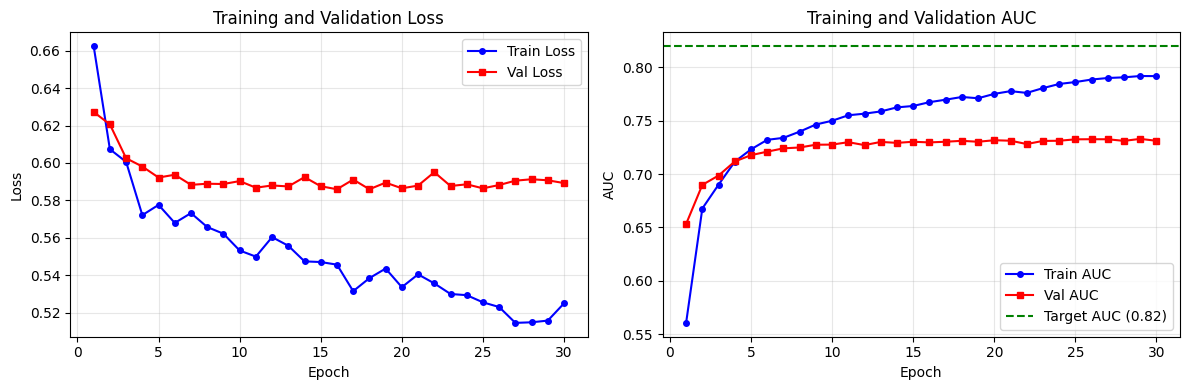

Training Summary:
----------------------------------------
Total epochs trained: 30
Best validation AUC: 0.7331
Final train AUC: 0.7919
Final validation AUC: 0.7312

Train-Val gap: 0.0607
Model might be overfitting


In [39]:
# CELL 15: Plot Training History

# Create figure with two subplots
plt.figure(figsize=(12, 4))

# Subplot 1: Loss curves
plt.subplot(1, 2, 1)
epochs = range(1, len(history['train_loss']) + 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o', markersize=4)
plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss', marker='s', markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: AUC curves
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_auc'], 'b-', label='Train AUC', marker='o', markersize=4)
plt.plot(epochs, history['val_auc'], 'r-', label='Val AUC', marker='s', markersize=4)
plt.axhline(y=0.82, color='g', linestyle='--', label='Target AUC (0.82)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print("-" * 40)
print(f"Total epochs trained: {len(history['train_loss'])}")
print(f"Best validation AUC: {max(history['val_auc']):.4f}")
print(f"Final train AUC: {history['train_auc'][-1]:.4f}")
print(f"Final validation AUC: {history['val_auc'][-1]:.4f}")

# Check for overfitting
final_gap = history['train_auc'][-1] - history['val_auc'][-1]
print(f"\nTrain-Val gap: {final_gap:.4f}")
if final_gap > 0.05:
    print("Model might be overfitting")
else:
    print("✓ No significant overfitting detected")

# CELL 16: Evaluate on Test Set

In [40]:
# CELL 16: Evaluate on Test Set

# Load best model
checkpoint = torch.load('best_sakt_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with val AUC {checkpoint['best_val_auc']:.4f}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_auc = validate_epoch(model, test_loader, criterion, device)

print(f"\nTest Set Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Compare with validation performance
print(f"\nGeneralization check:")
print(f"Validation AUC: {checkpoint['best_val_auc']:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Val-Test gap: {abs(checkpoint['best_val_auc'] - test_auc):.4f}")

# Additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get predictions for additional metrics
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        interactions = batch['interactions'].to(device)
        skills = batch['skills'].to(device)
        targets = batch['targets'].to(device)
        mask = batch['mask'].to(device)

        predictions = model(interactions, skills)

        valid_idx = mask == 1
        all_predictions.extend(predictions[valid_idx].cpu().numpy())
        all_targets.extend(targets[valid_idx].cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate additional metrics using 0.5 threshold
binary_predictions = (all_predictions > 0.5).astype(int)

accuracy = accuracy_score(all_targets, binary_predictions)
precision = precision_score(all_targets, binary_predictions)
recall = recall_score(all_targets, binary_predictions)
f1 = f1_score(all_targets, binary_predictions)

print(f"\nAdditional Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Loaded best model from epoch 29 with val AUC 0.7331

Evaluating on test set...



Test Set Results:
Test Loss: 0.5827
Test AUC: 0.7306

Generalization check:
Validation AUC: 0.7331
Test AUC: 0.7306
Val-Test gap: 0.0025

Additional Test Metrics:
Accuracy: 0.7030
Precision: 0.7260
Recall: 0.8554
F1-Score: 0.7854


# CELL 17: Save Final Model and Results

In [ ]:
# CELL 17: Save Final Model and Results

import json
from datetime import datetime

# Create results summary
results = {
    'model_name': 'SAKT',
    'dataset': 'ASSISTments2009',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'hyperparameters': {
        'num_skills': 145,
        'embed_dim': 128,
        'num_heads': 5,
        'dropout': 0.2,
        'learning_rate': 0.001,
        'batch_size': 64,
        'max_seq_len': 100
    },
    'results': {
        'best_val_auc': float(checkpoint['best_val_auc']),
        'test_auc': float(test_auc),
        'test_accuracy': float(accuracy),
        'test_precision': float(precision),
        'test_recall': float(recall),
        'test_f1': float(f1),
        'total_epochs': len(history['train_loss']),
        'best_epoch': checkpoint['epoch']
    },
    'data_stats': {
        'train_students': len(data['train']),
        'val_students': len(data['val']),
        'test_students': len(data['test']),
        'unique_skills': data['num_skills']
    }
}

# Save results to JSON
with open('sakt_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Save final model with all information
final_save = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results,
    'history': history,
    'skill_to_idx': data['skill_to_idx']
}

torch.save(final_save, 'sakt_final_model.pth')

print("Model and results saved!")
print(f"\nSummary for thesis:")
print(f"- SAKT achieved {test_auc:.4f} AUC on ASSISTments2009")
print(f"- Model has {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"- Training took {len(history['train_loss'])} epochs")

Model and results saved!

Summary for thesis:
- SAKT achieved 0.7349 AUC on ASSISTments2009
- Model has 382,081 parameters
- Training took 18 epochs
